In [27]:
# load necessary library
suppressPackageStartupMessages(library(GEOquery))
suppressPackageStartupMessages(library(oligo))

In [28]:
create.folders<-function(folder_names=NULL,location="."){
#     pass names or paths to create multiple folders 
#     and returns list of status as boolean

    paths<-file.path(location, folder_names)
    is_exists<-dir.exists(paths)
    paths<-paths[!is_exists]
    lapply(paths,function(path){
        dir.create(path, recursive = TRUE)
    })
    return(!is_exists)
    
}

remove.folders<-function(location=".",folder_names=NULL){
#   pass names or paths to remove multiple folders  
#   and returns list of boolean, if it now exists 
    
    paths<-file.path(location, folder_names)
    unlink(paths, recursive= T)
    return(!dir.exists(paths))
}

find.all.indeces<-function(query_list, vector){  
#   returns all matched indeces as a list.
    sapply(query_list,function(query) grep(query,vector))
}
           
extract_from_vector<-function(query_list, vector){
    store<-unique(unlist(lapply(query_list, function(query) grep(query, vector))
                  ))
    return(vector[store])
}
           
group_by_query<-function(query_names, vector, group_names=NULL){
#     it allocates group with first group name that matched if provided.
#     Otherwise allocate query name
    group<-rep(NA,length(vector))
    for(i in 1:length(vector)){
        for(j in 1:length(query_names)){
            if(is.na(group[i]) && !is.na(pmatch(query_names[j],vector[i])))
                if(!is.null(group_names) &&
                   length(group_names)==length(query_names))
                    group[i]<-group_names[j]
                else{group[i]<-query_names[j]}
            }
        }
      return(group)  
}
           
# if group_by_query fuction don't works due to query issues the use this
group_by_numbering<-function(group_numbering, vector, group_names=NULL){
#     gsub(pattern, replacement, string)
    group_numbering<- gsub(" ","",group_numbering)
    group <- rep(NA,length(vector))
    for (i in 1:nchar(group_numbering)){
        num<-as.numeric(substr(group_numbering,i,i))
        if(is.null(group_names)) 
            group[i] <- num
        else group[i] <- group_names[num]
        }
    return(group)
}
           
group_by_uniqueness<- function(vector, group_names=NULL){
    if(is.null(group_names)){
        uniq<- unique(vector)
        rename<-1:length(uniq)
        names(rename)<-uniq
        return(unname(rename[vector]))
    } 
    else {
        uniq<- unique(vector)
        names(group_names)<-uniq
        return(unname(group_names[vector]))
    }
}

fetch.geo.data<-function(GEO,filename=NULL,store_loc="."){
#     fetch published processed data and metadata from GEO database
    suppressPackageStartupMessages(library(GEOquery))
    if(!is.null(filename)) create.folders(file.path(store_loc,filename))
    else create.folders(filename)
    geo.data <- getGEO(GEO, filename=filename, destdir=store_loc, 
                     GSEMatrix=FALSE, AnnotGPL=TRUE, 
                     getGPL=TRUE)
    return(geo.data)
}

need.log.transformation<- function(data){
    qx <- as.numeric(quantile(data, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    # check if data need to be normalized 
    LogC <- (qx[5] > 100) ||
            (qx[6]-qx[1] > 50 && qx[2] > 0) ||
            (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    return(LogC)
}

sort.data<- function(data,columns,dec=FALSE){
    return(data[order(data[,columns],decreasing=dec),])
}

del.duplication<- function(data,column){
    return(data[!duplicated(data[,column]),])
}
           
setup_folder<-function(id){
    # create and set working directory if not exists
    if(!identical(tail(unlist(strsplit(getwd(), split = "/")), n=1), id)){
        if(!dir.exists(id)) {
        create.folders(id)
        setwd(dir =id )
    }
    else setwd(dir =id )
} 
}

In [29]:
getwd()

[1] "D:/biological data analysis/Parasites/GSE21936_L.dono_L.infantum"

In [30]:
# declare ccession number
my.gse<-c("GSE21936")
# set working directory
# setup_folder(my.gse)
# setwd('../GSE3835_L.dono/')
getwd()

[1] "D:/biological data analysis/Parasites/GSE21936_L.dono_L.infantum"

# Using GEOquery to Obtain Microarray Data<br>

The GEOquery package allows you to programmatically access data from GEO. Depending on your needs, you can download only the processed data and metadata provided by the depositor. In some cases, you may want to download the raw data as well, if it was provided by the depositor.

In [31]:
# create directory to store files downloaded from GEO and results anlyzed
create.folders(c("geo_downloads","results"))

[1] TRUE TRUE

In [32]:
#get published processed data and metadata from GEO
geo.gse <- getGEO(GEO=my.gse, filename=NULL, destdir="./geo_downloads", 
                     GSElimits=NULL, GSEMatrix=TRUE, AnnotGPL=FALSE, 
                     getGPL=FALSE)
geo.gse

Found 1 file(s)

GSE21936_series_matrix.txt.gz


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  ID_REF = col_double(),
  GSM545767 = col_double(),
  GSM545768 = col_double(),
  GSM545769 = col_double(),
  GSM545770 = col_double(),
  GSM545771 = col_double(),
  GSM545772 = col_double(),
  GSM545773 = col_double(),
  GSM545774 = col_double(),
  GSM545775 = col_double(),
  GSM545776 = col_double(),
  GSM545777 = col_double(),
  GSM545778 = col_double(),
  GSM545779 = col_double(),
  GSM545780 = col_double(),
  GSM545781 = col_double(),
  GSM545782 = col_double()
)




$GSE21936_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 8178 features, 16 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM545767 GSM545768 ... GSM545782 (16 total)
  varLabels: title geo_accession ... strain:ch1 (38 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
  pubMedIds: 20952481 
Annotation: GPL10446 


In [33]:
# data available from only one platform GPL16025
my.geo.gse <- geo.gse[[1]]
# object is now an ExpressionSet
class(my.geo.gse)

[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

In [34]:
# The phenotype data is contained inside pData slot. 
head(pData(my.geo.gse),3)
dim(pData(my.geo.gse))
# the expression matrix is contained inside exprs slot
head(exprs(my.geo.gse),3)
dim(exprs(my.geo.gse))

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,data_row_count,biological replicate:ch1,life cycle:ch1,strain:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM545767,0.0hr Biological Replicate 01,GSM545767,Public on Aug 15 2010,May 20 2010,May 20 2010,RNA,1,Leishmania donovani 1S promastigote,Leishmania donovani,strain: 1S,...,307 Westlake Ave N,Seattle,WA,98109,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM545nnn/GSM545767/suppl/GSM545767_1042402_532_pair.txt.gz,8178,1,promastigote (0 hour),1S
GSM545768,2.5hr Biological Replicate 01,GSM545768,Public on Aug 15 2010,May 20 2010,May 20 2010,RNA,1,Leishmania donovani 1S +2.5 hr differentiating,Leishmania donovani,strain: 1S,...,307 Westlake Ave N,Seattle,WA,98109,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM545nnn/GSM545768/suppl/GSM545768_1043802_532_pair.txt.gz,8178,1,2.5 hour differentiating,1S
GSM545769,5.0hr Biological Replicate 01,GSM545769,Public on Aug 15 2010,May 20 2010,May 20 2010,RNA,1,Leishmania donovani 1S +5 hr differentiating,Leishmania donovani,strain: 1S,...,307 Westlake Ave N,Seattle,WA,98109,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM545nnn/GSM545769/suppl/GSM545769_1044102_532_pair.txt.gz,8178,1,5.0 hour differentiating,1S


[1] 16 38

,GSM545767,GSM545768,GSM545769,GSM545770,GSM545771,GSM545772,GSM545773,GSM545774,GSM545775,GSM545776,GSM545777,GSM545778,GSM545779,GSM545780,GSM545781,GSM545782
4767651,1863.5,1737.0,2453.1,4182.3,3013.2,4417.3,2696.8,679.8,1066.7,1746.2,1981.7,2637.0,2835.2,3196.3,2438.3,759.6
4767652,156.3,189.5,250.1,343.8,166.7,266.3,191.0,103.3,103.6,150.0,104.5,135.7,158.8,167.6,143.2,119.7
4767653,653.2,568.3,465.3,419.3,350.3,415.8,303.9,172.4,657.3,499.0,522.5,476.6,466.4,369.3,297.5,222.6


[1] 8178   16

In [35]:
pData(my.geo.gse)$title

[1] "0.0hr Biological Replicate 01" "2.5hr Biological Replicate 01"
 [3] "5.0hr Biological Replicate 01" "7.5hr Biological Replicate 01"
 [5] "10hr Biological Replicate 01"  "15hr Biological Replicate 01" 
 [7] "24hr Biological Replicate 01"  "144hr Biological Replicate 01"
 [9] "0.0hr Biological Replicate 02" "2.5hr Biological Replicate 02"
[11] "5.0hr Biological Replicate 02" "7.5hr Biological Replicate 02"
[13] "10hr Biological Replicate 02"  "15hr Biological Replicate 02" 
[15] "24hr Biological Replicate 02"  "144hr Biological Replicate 02"

# Preparing the Phenodata

In [52]:
# make data frame of phenotypic Data
pdata <- as.data.frame(pData(my.geo.gse), stringsAsFactors=F)

names<-c("title","geo_accession","source_name","organism","species" ,"strain","time")
my.pdata<- pdata[,extract_from_vector(names, colnames(pdata))]
head(my.pdata,2)

,title,geo_accession,source_name_ch1,organism_ch1,strain:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>
GSM545767,0.0hr Biological Replicate 01,GSM545767,Leishmania donovani 1S promastigote,Leishmania donovani,1S
GSM545768,2.5hr Biological Replicate 01,GSM545768,Leishmania donovani 1S +2.5 hr differentiating,Leishmania donovani,1S


In [53]:
my.pdata

,title,geo_accession,source_name_ch1,organism_ch1,strain:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>
GSM545767,0.0hr Biological Replicate 01,GSM545767,Leishmania donovani 1S promastigote,Leishmania donovani,1S
GSM545768,2.5hr Biological Replicate 01,GSM545768,Leishmania donovani 1S +2.5 hr differentiating,Leishmania donovani,1S
GSM545769,5.0hr Biological Replicate 01,GSM545769,Leishmania donovani 1S +5 hr differentiating,Leishmania donovani,1S
GSM545770,7.5hr Biological Replicate 01,GSM545770,Leishmania donovani 1S +10 hr differentiating,Leishmania donovani,1S
GSM545771,10hr Biological Replicate 01,GSM545771,Leishmania donovani 1S +7.5 hr differentiating,Leishmania donovani,1S
GSM545772,15hr Biological Replicate 01,GSM545772,Leishmania donovani 1S +24 hr differentiating,Leishmania donovani,1S
GSM545773,24hr Biological Replicate 01,GSM545773,Leishmania donovani 1S +15 hr differentiating,Leishmania donovani,1S
GSM545774,144hr Biological Replicate 01,GSM545774,Leishmania donovani 1S amastigote,Leishmania donovani,1S
GSM545775,0.0hr Biological Replicate 02,GSM545775,Leishmania donovani 1S promastigote,Leishmania donovani,1S


In [77]:
group_num<-c("12345678 12345678")
group_names<-paste("L.dono",c("0hr","2.5hr","5hr","7.5hr","10hr","15hr","24hr","144hr"),sep="_")
# allocate groups
my.pdata[["group"]]<-group_by_numbering(group_num, pdata$title, group_names)
# num of replicates in each group
table(my.pdata$group)


  L.dono_0hr  L.dono_10hr L.dono_144hr  L.dono_15hr L.dono_2.5hr  L.dono_24hr 
           2            2            2            2            2            2 
  L.dono_5hr L.dono_7.5hr 
           2            2 

In [78]:
suppressPackageStartupMessages(library(RColorBrewer))
# select colour for each group
group.color <- brewer.pal(8, "Dark2")
names(group.color)<-unique(my.pdata$group)
# allocate colour to each sample
sample.color <- unname(group.color[my.pdata$group])
my.pdata[["color"]]<- sample.color
sample.color

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E" "#E6AB02" "#A6761D"
 [8] "#666666" "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E" "#E6AB02"
[15] "#A6761D" "#666666"

In [79]:
# store processed phenotype data
write.table(pdata, file=paste0("results/",my.gse,"_PhenoData.txt"), 
            sep="\t", quote=F,col.names=NA)

# Preparing Gene Expression Data<br>

## Normalize Expression Data

In [80]:
assayData<-exprs(my.geo.gse)
# check if data need to be normalized 
LogC<-need.log.transformation(assayData)
LogC

[1] TRUE

In [81]:
if (LogC) { 
    assayData[which(assayData<= 0)] <- NaN
    # take log2 transform
    assayData<-na.omit(log2(assayData))
}
# prpare an Expression Set
my.rma<-ExpressionSet(assayData=assayData,
                      phenoData=AnnotatedDataFrame(my.pdata))
head(exprs(my.rma),3)

,GSM545767,GSM545768,GSM545769,GSM545770,GSM545771,GSM545772,GSM545773,GSM545774,GSM545775,GSM545776,GSM545777,GSM545778,GSM545779,GSM545780,GSM545781,GSM545782
4767651,10.863799,10.762382,11.260390,12.030081,11.557081,12.108949,11.397033,9.408967,10.058939,10.770003,10.952523,11.364682,11.469235,11.642187,11.251660,9.569096
4767652,7.288174,7.566054,7.966361,8.425426,7.381110,8.056909,7.577429,6.690696,6.694880,7.228819,6.707359,7.084277,7.311067,7.388878,7.161888,6.903279
4767653,9.351381,9.150509,8.862017,8.711839,8.452447,8.699746,8.247453,7.429616,9.360408,8.962896,9.029287,8.896635,8.865424,8.528649,8.216746,7.798310


In [82]:
# save expression values
write.table(exprs(my.rma), file=paste0("results/",my.gse,"_NormExprsData.txt"),
            sep="\t", quote=FALSE, col.names=NA)

## Check Normalization

In [83]:
suppressPackageStartupMessages(library(limma))

In [84]:
create.folders(c("results/SamplesPlot"))

[1] FALSE

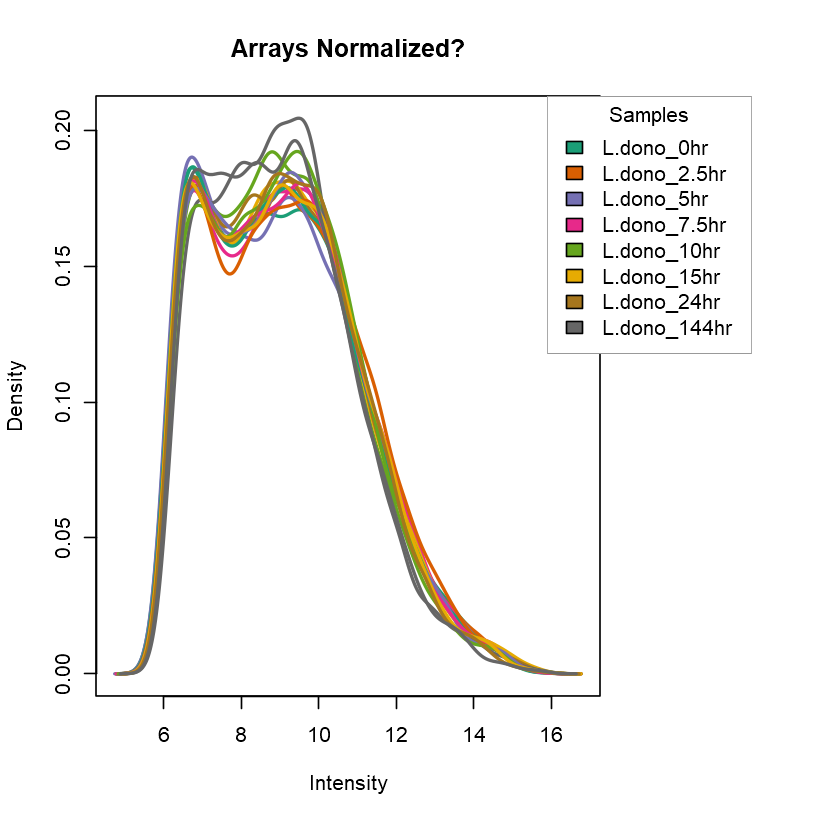

In [85]:
# svg("results/SamplesPlot/DensityPlot.svg")
par(mar=c(6,4,4,10),xpd=TRUE)
plotDensities(exprs(my.rma), legend=F, col=sample.color, main="Arrays Normalized?")
legend("topright",title="Samples",inset=c(-0.30,0),box.lwd=0.2, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

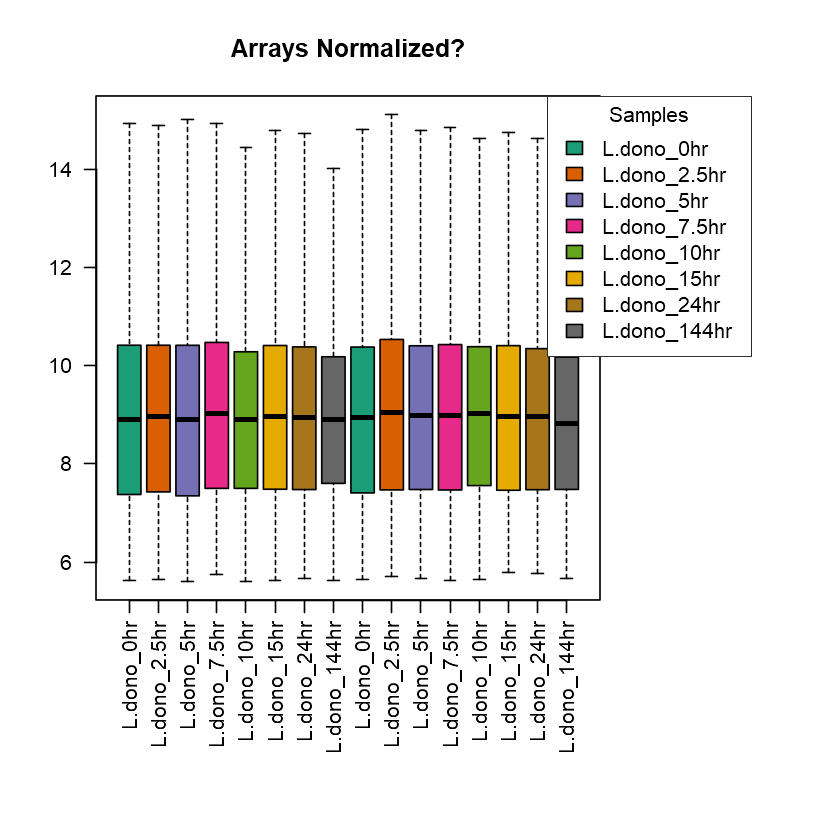

In [86]:
# svg("results/SamplesPlot/BoxPlot.svg")
par(mar=c(10,4,4,10),xpd=TRUE)
boxplot(exprs(my.rma), las=2, names=pData(my.rma)$group, 
        outline=F, col=sample.color, main="Arrays Normalized?")
legend("topright",title="Samples",inset=c(-0.30,0),box.lwd=0.5, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

## Checking variation across sample<br>
we are mainly checking for consistency between biological replicates of the same treatment.

### Principle component analysis

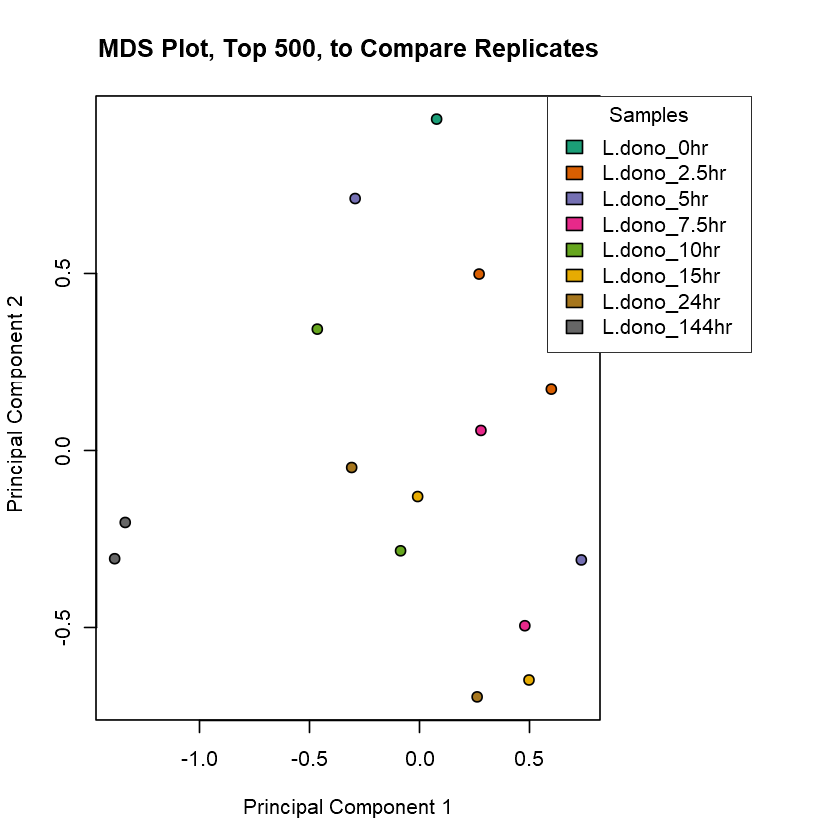

In [87]:
# svg("results/SamplesPlot/PCA_Plot.svg")
par(mar=c(5,4,4,10),xpd=TRUE)
limma::plotMDS(exprs(my.rma),top=500, pch=rep(21, 7), 
         bg=sample.color, gene.selection="common", 
        main="MDS Plot, Top 500, to Compare Replicates",
#         labels=unique(pData(my.rma)$group),
              )

legend("topright",title="Samples",inset=c(-0.30,0),box.lwd=0.5, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()


### Hierarchical Clustering

`z-score = (rma-sample - rma-mean) / rma-sd`

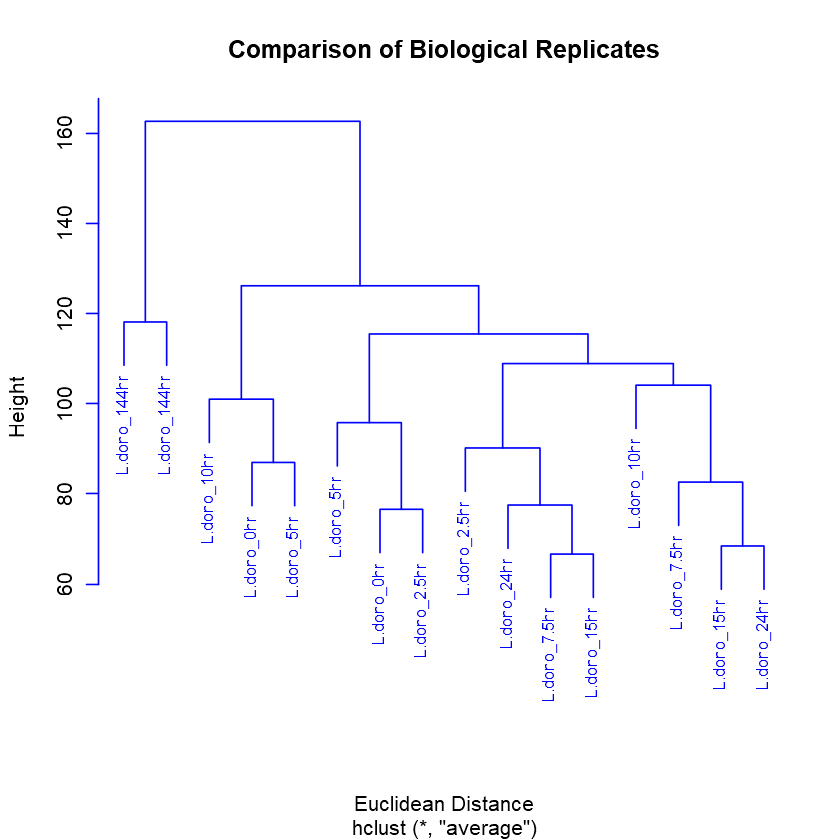

In [88]:
# cal z-score
cluster.dat <- exprs(my.rma)
gene.mean <- apply(cluster.dat, 1, mean)
gene.sd <- apply(cluster.dat, 1, sd)
cluster.dat <- sweep(cluster.dat, 1, gene.mean, "-")
cluster.dat <- sweep(cluster.dat, 1, gene.sd, "/")

my.dist <- dist(t(cluster.dat), method="euclidean")
my.hclust <- hclust(my.dist, method="average")
my.hclust$labels <- pData(my.rma)$group
# svg("results/SamplesPlot/HierarchicalPlot.svg")
plot(my.hclust, cex=0.75,col="blue",
     main="Comparison of Biological Replicates", 
      xlab="Euclidean Distance")
# dev.off()

### Removing Low Expression Data

To reduce the possibility for type I errors is to do fewer comparisons. This can be done by filtering the data. For example, we know that not all genes are expressed in all tissues and many genes will not be expressed in any sample. As a result, DGE analysis, it makes sense to remove probesets for genes that likely not expressed at all.

In [89]:
table(exprs(my.rma)<0)


 FALSE 
130848 

no genes have expression zero

In [90]:
as.numeric(quantile(exprs(my.rma), c(0., 0.025, 0.05, 0.075, 0.099, .10), na.rm=T))

[1] 5.611763 6.203593 6.357552 6.490249 6.616181 6.622052

***We now have the metadata and phenodata (sample data) for this experiment. The expression data is in format that could be used for differential gene expression (DGE) analysis.***

# DGE with Limma

In [91]:
# check if rows of phenotype is sorted same way as columns of exprs matrix
table(rownames(pData(my.rma))==colnames(exprs(my.rma)))


TRUE 
  16 

## Design Matrix

In [92]:
# prepare design matrix
sample.lst<-pData(my.rma)$group
group.lst<-factor(sample.lst)

my.design <- model.matrix(~0 + group, pData(my.rma))

rownames(my.design) <- sample.lst
colnames(my.design) <- levels(group.lst)

my.design

,L.dono_0hr,L.dono_10hr,L.dono_144hr,L.dono_15hr,L.dono_2.5hr,L.dono_24hr,L.dono_5hr,L.dono_7.5hr
L.dono_0hr,1,0,0,0,0,0,0,0
L.dono_2.5hr,0,0,0,0,1,0,0,0
L.dono_5hr,0,0,0,0,0,0,1,0
L.dono_7.5hr,0,0,0,0,0,0,0,1
L.dono_10hr,0,1,0,0,0,0,0,0
L.dono_15hr,0,0,0,1,0,0,0,0
L.dono_24hr,0,0,0,0,0,1,0,0
L.dono_144hr,0,0,1,0,0,0,0,0
L.dono_0hr,1,0,0,0,0,0,0,0
L.dono_2.5hr,0,0,0,0,1,0,0,0


In [94]:
# fit linear model
fit <- lmFit(my.rma, my.design)

In [96]:
# specify the comparison btw group of interest
my.contrasts <- makeContrasts(L.dono_2.5vs0hr= L.dono_2.5hr-L.dono_0hr,
                              L.dono_5vs0hr= L.dono_5hr-L.dono_0hr,
                              L.dono_7.5vs0hr= L.dono_7.5hr-L.dono_0hr,
                              L.dono_10vs0hr= L.dono_10hr-L.dono_0hr,
                              L.dono_15vs0hr= L.dono_15hr-L.dono_0hr,
                              L.dono_24vs0hr= L.dono_24hr-L.dono_0hr,
                              L.dono_144vs0hr= L.dono_144hr-L.dono_0hr
                            , levels = my.design)
my.contrasts

,L.dono_2.5vs0hr,L.dono_5vs0hr,L.dono_7.5vs0hr,L.dono_10vs0hr,L.dono_15vs0hr,L.dono_24vs0hr,L.dono_144vs0hr
L.dono_0hr,-1,-1,-1,-1,-1,-1,-1
L.dono_10hr,0,0,0,1,0,0,0
L.dono_144hr,0,0,0,0,0,0,1
L.dono_15hr,0,0,0,0,1,0,0
L.dono_2.5hr,1,0,0,0,0,0,0
L.dono_24hr,0,0,0,0,0,1,0
L.dono_5hr,0,1,0,0,0,0,0
L.dono_7.5hr,0,0,1,0,0,0,0


In [97]:
# store comparison matrix
write.table(my.contrasts, file=paste0("results/",my.gse,"_Comparisons.txt"), 
            sep="\t", quote=F,col.names=NA)

## Statistical Inference

In [98]:
fits.fun<-function(x)(contrasts.fit(fit, contrasts=my.contrasts[, x]));

contrast.fits <- lapply(colnames(my.contrasts),fits.fun)
names(contrast.fits)<-colnames(my.contrasts)

In [99]:
ebs.fun<-function(x)(eBayes(x, proportion=0.1, trend=FALSE, robust=FALSE))
    
contrast.ebs <- lapply(contrast.fits, ebs.fun)

In [100]:
tts.fun<-function(x)(topTable(x, adjust.method="BH", number=length(x$coefficients), sort.by="none"));

contrast.tts <- lapply(contrast.ebs,tts.fun)

In [101]:
test.fun<-function(x){
    store<-decideTests(x, method="separate", 
                                  adjust.method="BH", p.value=0.05, 
                                  lfc=0)
    return(store)
};

contrast.tests <- lapply(contrast.ebs, test.fun)


In [102]:
contrast.tests.df<-lapply(contrast.tests,function(x){
    store<-as.data.frame(x)
    colnames(store)<-"test"
    return(store)
})

In [103]:
head(contrast.tests.df[[1]])

,test
,<dbl>
4767651,0
4767652,0
4767653,0
4767654,0
4767655,0
4767656,0


In [104]:
# show in one matrix whether up or down regulated in diff comparisons
tests.mat <- do.call(cbind, contrast.tests)
colnames(tests.mat) <- names(contrast.tests)
write.table(tests.mat, file=paste0("results/",my.gse,"_Test.txt"), 
            sep="\t", quote=F, col.names=NA)

In [105]:
head(tests.mat,3)

,L.dono_2.5vs0hr,L.dono_5vs0hr,L.dono_7.5vs0hr,L.dono_10vs0hr,L.dono_15vs0hr,L.dono_24vs0hr,L.dono_144vs0hr
4767651,0,0,1,0,1,0,-1
4767652,0,0,0,0,0,0,0
4767653,0,0,0,0,0,-1,-1


# Gene Annotations for Microarray Probesets

In [130]:
gpl <- read.table("results/Annotation_file.txt",header=T,sep="\t",quote="")
head(gpl)

,Gene.ID,source_id,Organism,Genomic.Location..Gene.,Product.Description,Gene.Type,ORF,Symbol,ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,LINF_010005000,LINF_010005000-T1,Leishmania infantum JPCM5,"""LinJ.01:3,710..4,711(-)""",Protein of unknown function (DUF2946),protein coding,LinJ01.0010,N/A,4767651
2,LINF_010005100,LINF_010005100-T1,Leishmania infantum JPCM5,"""LinJ.01:5,804..7,438(-)""",Endonuclease/Exonuclease/phosphatase family,protein coding,LinJ01.0020,N/A,4767652
3,LINF_010005200,LINF_010005200-T1,Leishmania infantum JPCM5,"""LinJ.01:9,038..11,059(-)""",Kinesin-13,protein coding,LinJ01.0030,KIN13-1,4767653
4,LINF_010005300,LINF_010005300-T1,Leishmania infantum JPCM5,"""LinJ.01:12,041..12,601(-)""",hypothetical protein - conserved,protein coding,LinJ01.0040,N/A,4767654
5,LINF_010005400,LINF_010005400-T1,Leishmania infantum JPCM5,"""LinJ.01:14,957..16,954(-)""",carboxylase - putative,protein coding,LinJ01.0050,N/A,4767655
6,LINF_010005500,LINF_010005500-T1,Leishmania infantum JPCM5,"""LinJ.01:18,110..18,859(-)""",hypothetical protein - conserved,protein coding,LinJ01.0060,N/A,4767656


In [131]:
platform<- gpl[,extract_from_vector(c('ID','Product.Description','ORF','Symbol'),
                                   colnames(gpl))]
head(platform)

,Gene.ID,ID,Product.Description,ORF,Symbol
,<chr>,<int>,<chr>,<chr>,<chr>
1,LINF_010005000,4767651,Protein of unknown function (DUF2946),LinJ01.0010,N/A
2,LINF_010005100,4767652,Endonuclease/Exonuclease/phosphatase family,LinJ01.0020,N/A
3,LINF_010005200,4767653,Kinesin-13,LinJ01.0030,KIN13-1
4,LINF_010005300,4767654,hypothetical protein - conserved,LinJ01.0040,N/A
5,LINF_010005400,4767655,carboxylase - putative,LinJ01.0050,N/A
6,LINF_010005500,4767656,hypothetical protein - conserved,LinJ01.0060,N/A


In [138]:
colnames(platform)<-c('Gene.ID','ID','Product','ORF','Symbol')
head(platform,5)

,Gene.ID,ID,Product,ORF,Symbol
,<chr>,<int>,<chr>,<chr>,<chr>
1,LINF_010005000,4767651,Protein of unknown function (DUF2946),LinJ01.0010,N/A
2,LINF_010005100,4767652,Endonuclease/Exonuclease/phosphatase family,LinJ01.0020,N/A
3,LINF_010005200,4767653,Kinesin-13,LinJ01.0030,KIN13-1
4,LINF_010005300,4767654,hypothetical protein - conserved,LinJ01.0040,N/A
5,LINF_010005400,4767655,carboxylase - putative,LinJ01.0050,N/A


In [139]:
my.annotated.results<-lapply(colnames(my.contrasts),function(x){  
    store<-merge(contrast.tts[[x]], contrast.tests.df[[x]], by="row.names",all.x=FALSE)
    colnames(store)[1]<-"ID"

    store<-merge(platform, store, by="ID")
    return(store)
})
names(my.annotated.results)<-colnames(my.contrasts)

In [140]:
head(my.annotated.results[[1]],3)

,ID,Gene.ID,Product,ORF,Symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,test
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4767651,LINF_010005000,Protein of unknown function (DUF2946),LinJ01.0010,N/A,0.3048236,11.029188,1.0354378,0.3222037,0.9999089,-2.371439,0
2,4767652,LINF_010005100,Endonuclease/Exonuclease/phosphatase family,LinJ01.0020,N/A,0.4059093,7.339538,0.8602091,0.4076273,0.9999089,-2.478405,0
3,4767653,LINF_010005200,Kinesin-13,LinJ01.0030,KIN13-1,-0.2991921,8.660210,-1.4743175,0.1678145,0.9999089,-2.043192,0


## Cases of genes with two or more probes, only the most significant ones were used.

In [141]:
my.unique.results <- lapply(colnames(my.contrasts), function(x){
    ordered.result<-my.annotated.results[[x]][order(my.annotated.results[[x]]$ID,
              my.annotated.results[[x]]$adj.P.Val,decreasing=FALSE),]
    return(ordered.result[!duplicated(ordered.result$ID),])
})
names(my.unique.results) <- colnames(my.contrasts)

In [142]:
# check if duplication still exists
print(length(my.unique.results[[1]]$ID))
table(duplicated(my.unique.results[[1]]$ID))

[1] 6914



FALSE 
 6914 

## Combine different time point comparison of a strain

In [143]:
names(my.unique.results)

[1] "L.dono_2.5vs0hr" "L.dono_5vs0hr"   "L.dono_7.5vs0hr" "L.dono_10vs0hr" 
[5] "L.dono_15vs0hr"  "L.dono_24vs0hr"  "L.dono_144vs0hr"

In [152]:
store.list<-my.unique.results
names<-names(store.list)    
for(x in names){
#     1st comparison
    if(which(x==names)==1){
        combined<-store.list[[x]][,c("ID","ORF","Product","Symbol","logFC","test")]
        colnames(combined)[5:6]<-paste(x,c("logFC","test"),sep="_")
        } 
    else{
        colnames(store.list[[x]])<-paste(x,colnames(store.list[[x]]),sep="_")
        colnames(store.list[[x]])[which(colnames(store.list[[x]])==paste(x,"ID",sep="_"))]<-c("ID")
        combined<-merge(combined,store.list[[x]][,c(c("ID"),paste(x,c("logFC","test"),sep="_"))],by="ID")
        }
}

In [153]:
head(combined,3)

,ID,ORF,Product,Symbol,L.dono_2.5vs0hr_logFC,L.dono_2.5vs0hr_test,L.dono_5vs0hr_logFC,L.dono_5vs0hr_test,L.dono_7.5vs0hr_logFC,L.dono_7.5vs0hr_test,L.dono_10vs0hr_logFC,L.dono_10vs0hr_test,L.dono_15vs0hr_logFC,L.dono_15vs0hr_test,L.dono_24vs0hr_logFC,L.dono_24vs0hr_test,L.dono_144vs0hr_logFC,L.dono_144vs0hr_test
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4767651,LinJ01.0010,Protein of unknown function (DUF2946),N/A,0.3048236,0,0.6450877,0,1.2360124,1,1.0517888,0,1.4141992,1,0.8629774,0,-0.9723376,-1
2,4767652,LinJ01.0020,Endonuclease/Exonuclease/phosphatase family,N/A,0.4059093,0,0.3453331,0,0.7633242,0,0.3545616,0,0.7313664,0,0.3781312,0,-0.1945392,0
3,4767653,LinJ01.0030,Kinesin-13,KIN13-1,-0.2991921,0,-0.4102423,0,-0.5516575,0,-0.6969590,0,-0.7416969,0,-1.1237952,-1,-1.7419317,-1


In [154]:
# store results
write.table(combined, 
            file=paste0("results/","CombinedGenes.txt"), 
                sep="\t", quote=F, row.names=FALSE)

## Filter genes that are significant in atleast one comparison

In [155]:
store.test<- 1*(combined[,grep("test",colnames(combined))]!=0)
# select genes that was significant in atleast one time point 
filtered<-combined[apply(store.test,1,sum)>=1,]
store.logFC<-filtered[,grep("logFC",colnames(filtered))]
# sort genes according in logFC
significant.genes<-filtered[order(apply(store.logFC,1,sum),decreasing=TRUE),]

In [156]:
head(significant.genes,3)

,ID,ORF,Product,Symbol,L.dono_2.5vs0hr_logFC,L.dono_2.5vs0hr_test,L.dono_5vs0hr_logFC,L.dono_5vs0hr_test,L.dono_7.5vs0hr_logFC,L.dono_7.5vs0hr_test,L.dono_10vs0hr_logFC,L.dono_10vs0hr_test,L.dono_15vs0hr_logFC,L.dono_15vs0hr_test,L.dono_24vs0hr_logFC,L.dono_24vs0hr_test,L.dono_144vs0hr_logFC,L.dono_144vs0hr_test
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3714,4772174,LinJ28.0980,oxidoreductase-like protein,N/A,2.878916,0,3.285026,1,4.522974,1,4.732490,1,5.411968,1,5.553780,1,4.441806,1
5368,4774177,LinJ34.0070,ascorbate peroxidase,APX,2.643791,1,2.929185,1,3.037255,1,3.182229,1,3.127280,1,3.035045,1,3.119139,1
4068,4772598,LinJ29.1890,hypothetical protein - conserved,N/A,1.231721,0,1.760687,0,3.077016,1,2.782349,1,3.504510,1,3.507677,1,3.230179,1


In [157]:
# store results
write.table(significant.genes, 
            file=paste0("results/","SignificantGenes.txt"), 
                sep="\t", quote=F, row.names=FALSE)

# Visualizing the Results

The function plotMA will produce a scatter plot of average log2 expression on the x-axis vs. log2 fold change on the y-axis.

## MAPlot 

In [120]:
create.folders("results/SamplesPlot/MAPlot")

[1] TRUE

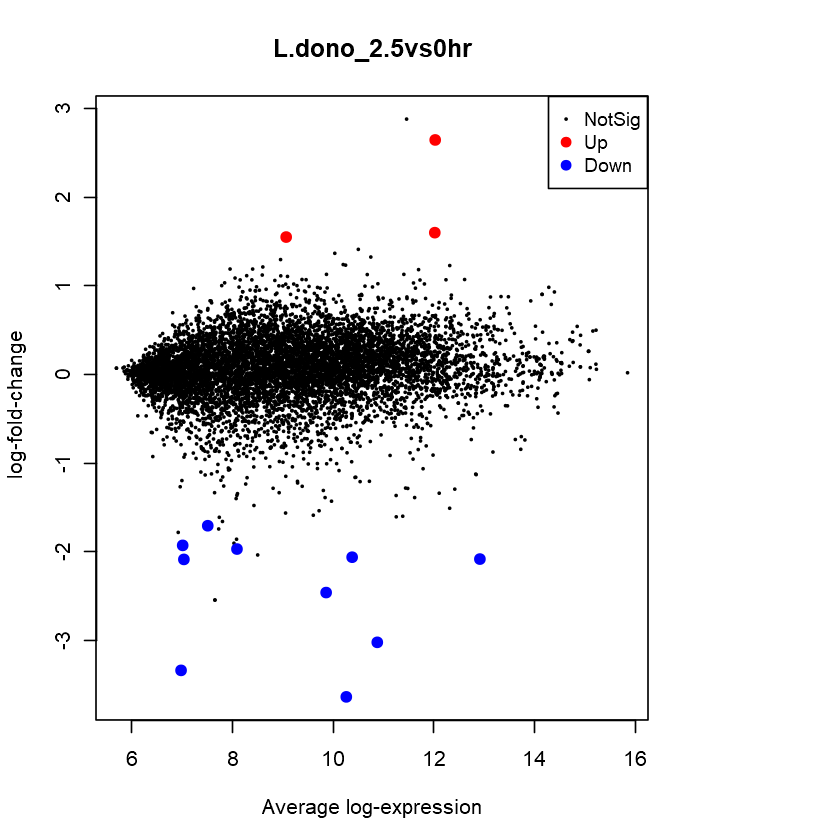

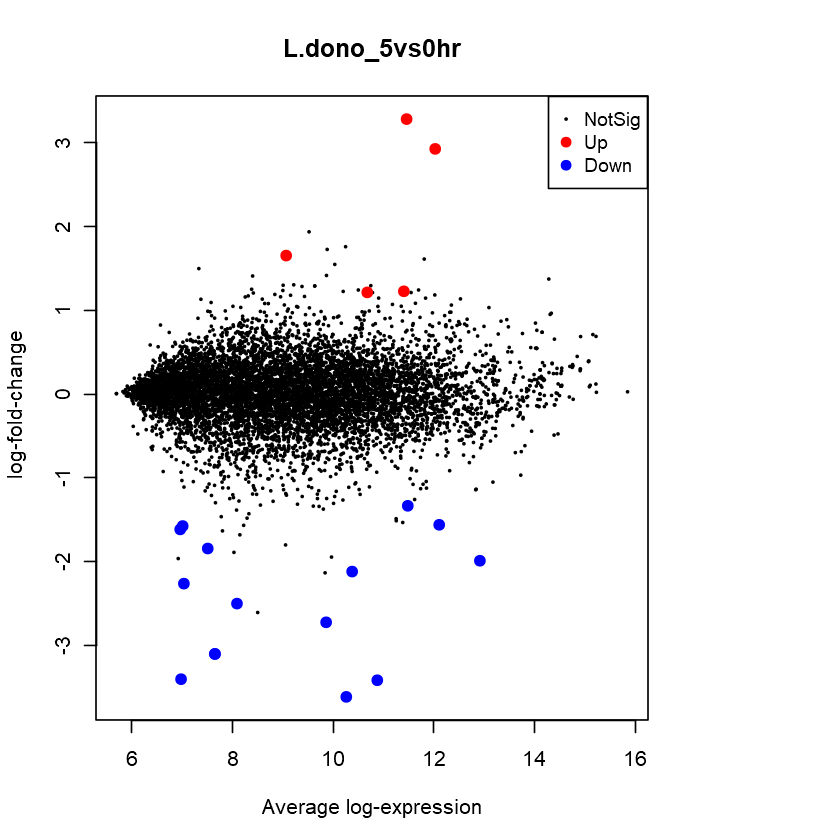

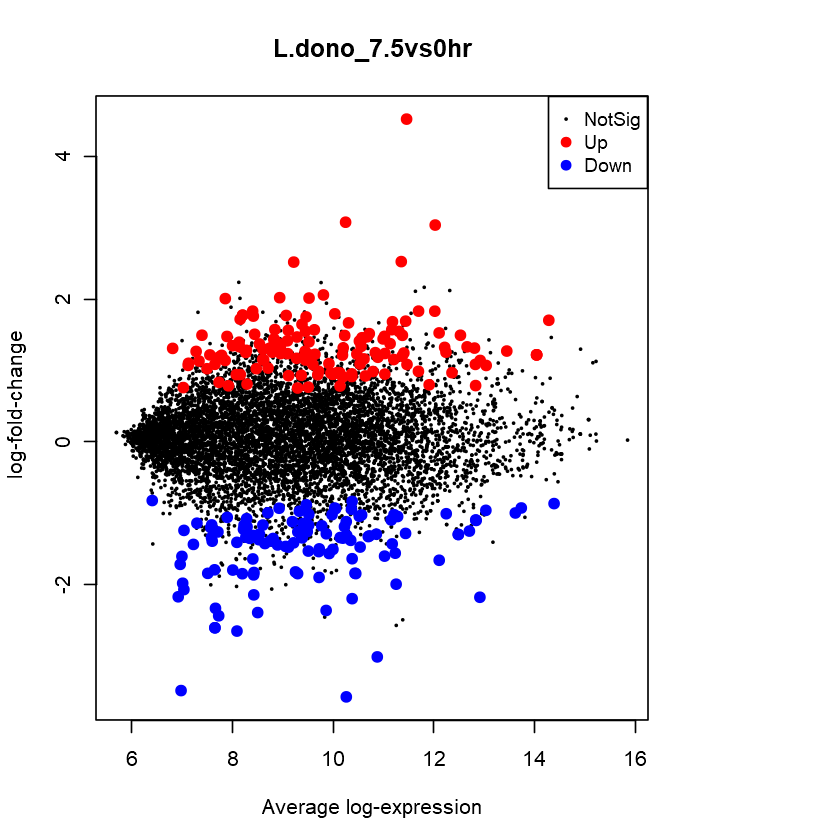

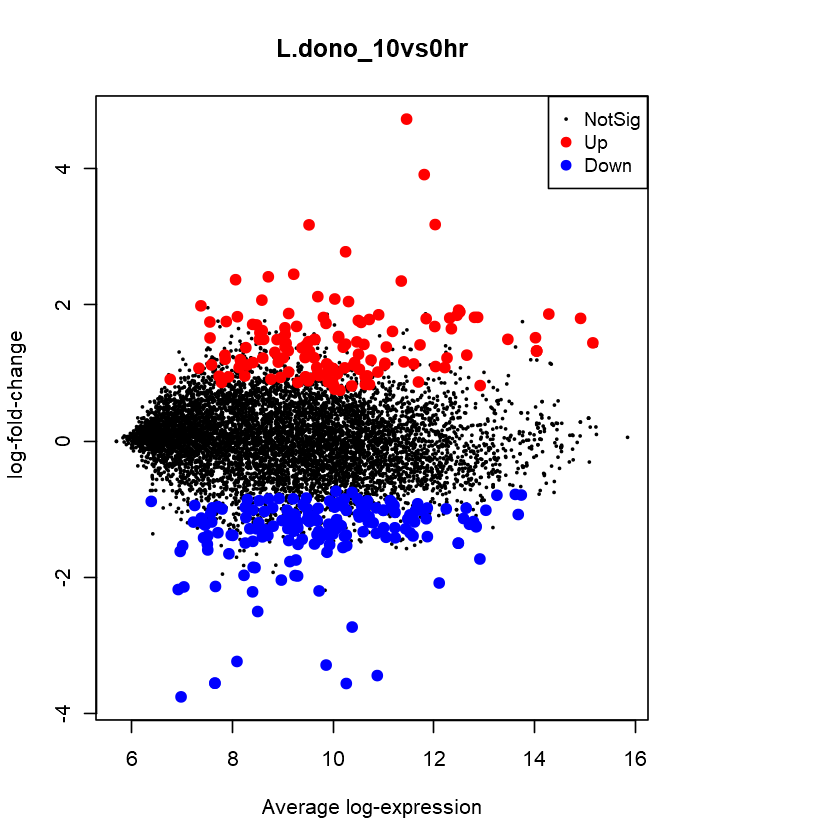

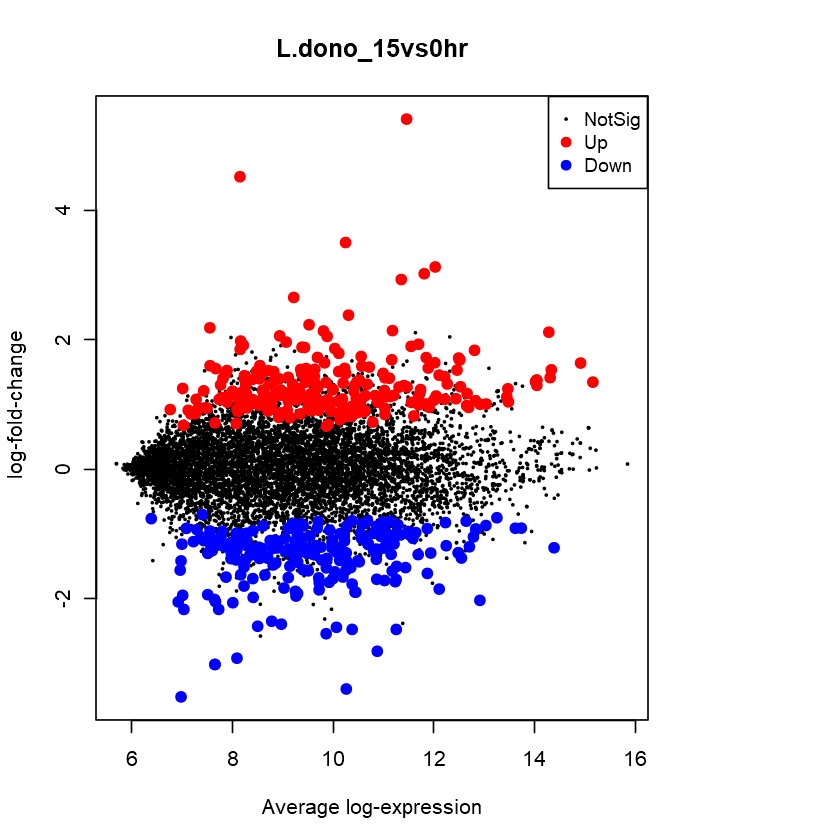

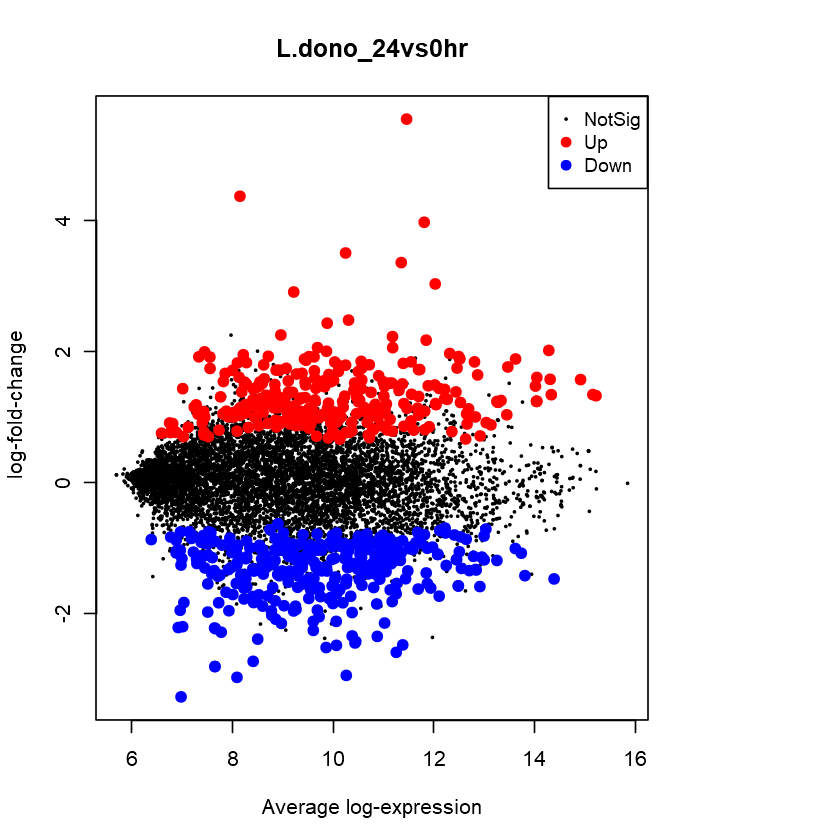

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

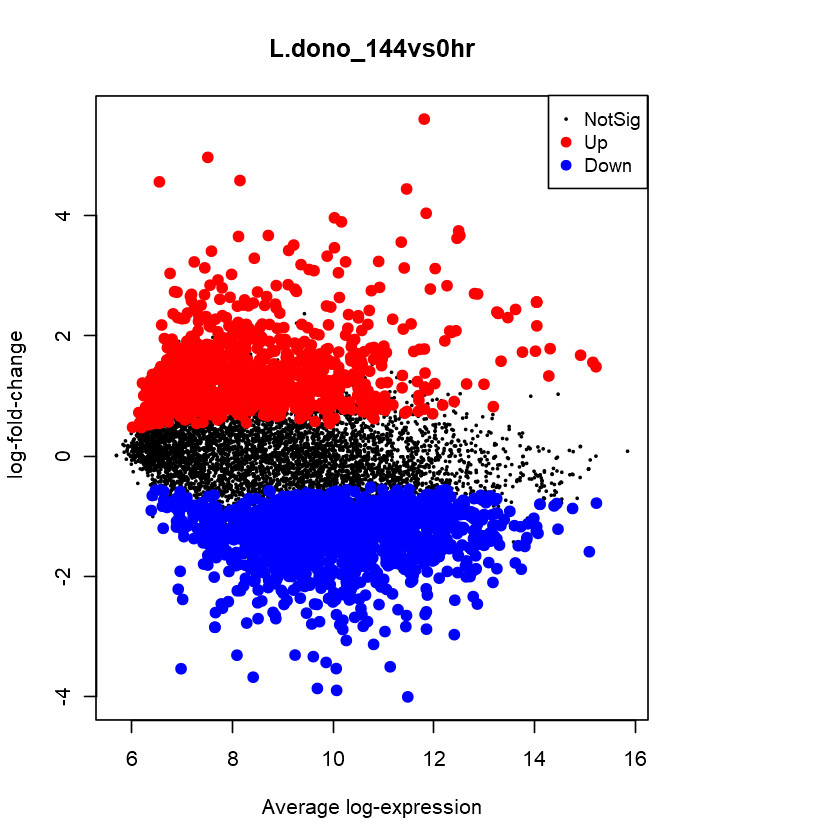

In [121]:
# chosing different color for up, down and not regulated probes, using tests 1,-1,0 marking.
ma.cols <- c(brewer.pal(11, "RdBu")[10], "grey50", brewer.pal(11, "RdBu")[2])
names(ma.cols)<-c(-1,0,1)

names<-names(my.unique.results)
lapply(names,function(x){
    
#         svg(file=paste0("results/SamplesPlot/MAPlot/",x,"_MAPlot.svg"))  
    par(mar=c(5,4,4,8),xpd=TRUE)
        # assign above color to the rows,probeids.
    row.colors <- unname(ma.cols[as.character(contrast.tests[[x]][, 1])])
        
    limma::plotMA(contrast.ebs[[x]], status=contrast.tests[[x]],
                col=row.colors, pch=19, main=x)  
#         abline(h=1,col="red")
#         abline(h=-1,col="blue" )
#         dev.off()
    })

## Volcano Plot

volcano plot which plot logFC on the x-axis and p-value (-log10) on the y-axis.

In [122]:
create.folders("results/SamplesPlot/VolcanoPlot")

[1] TRUE

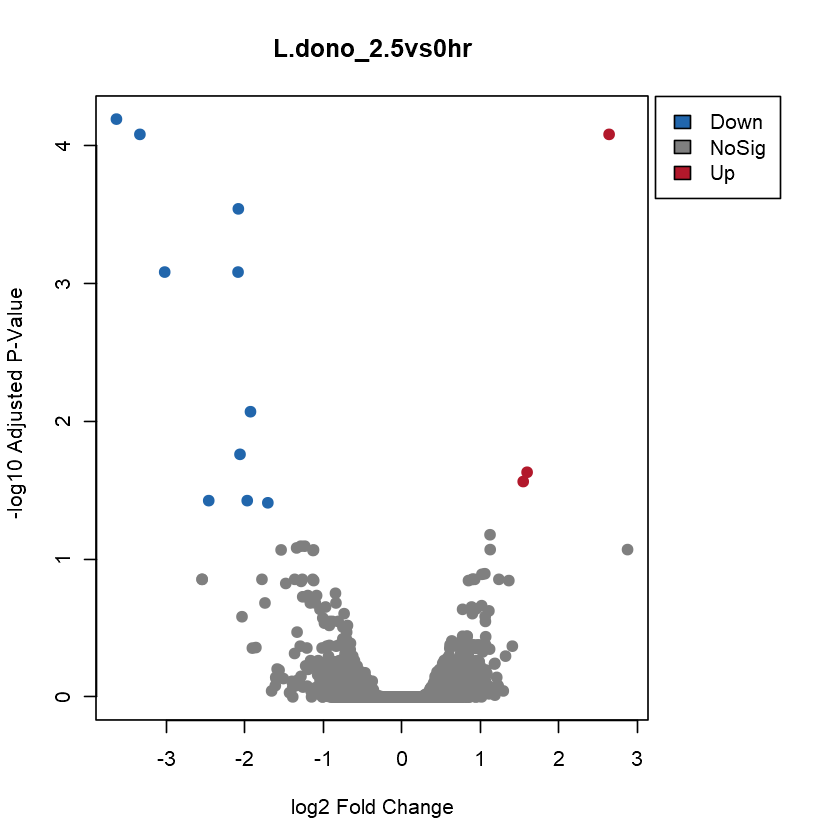

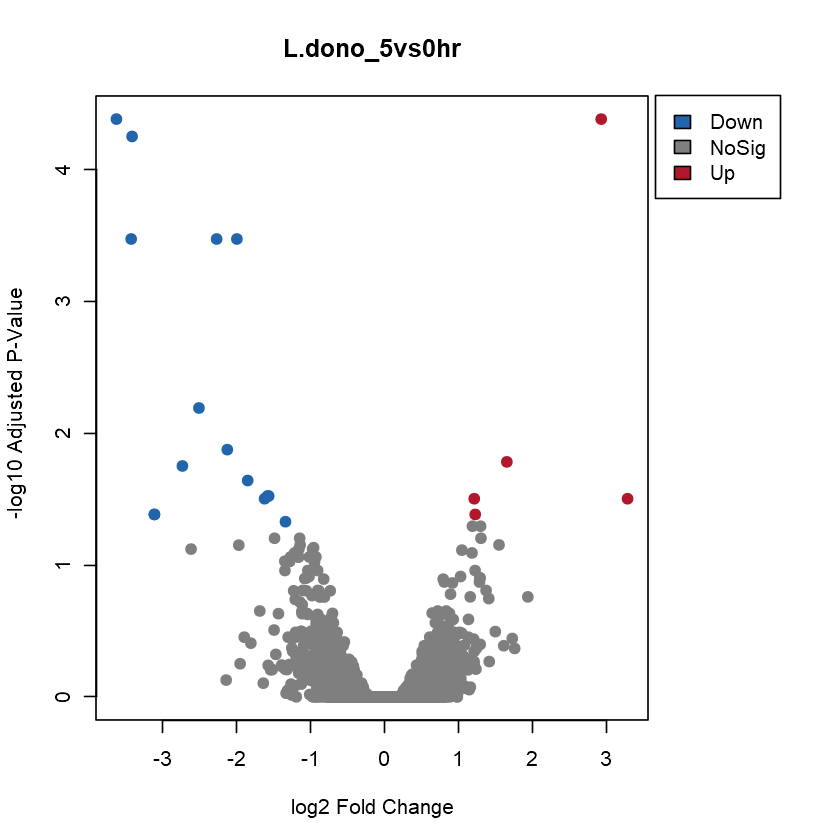

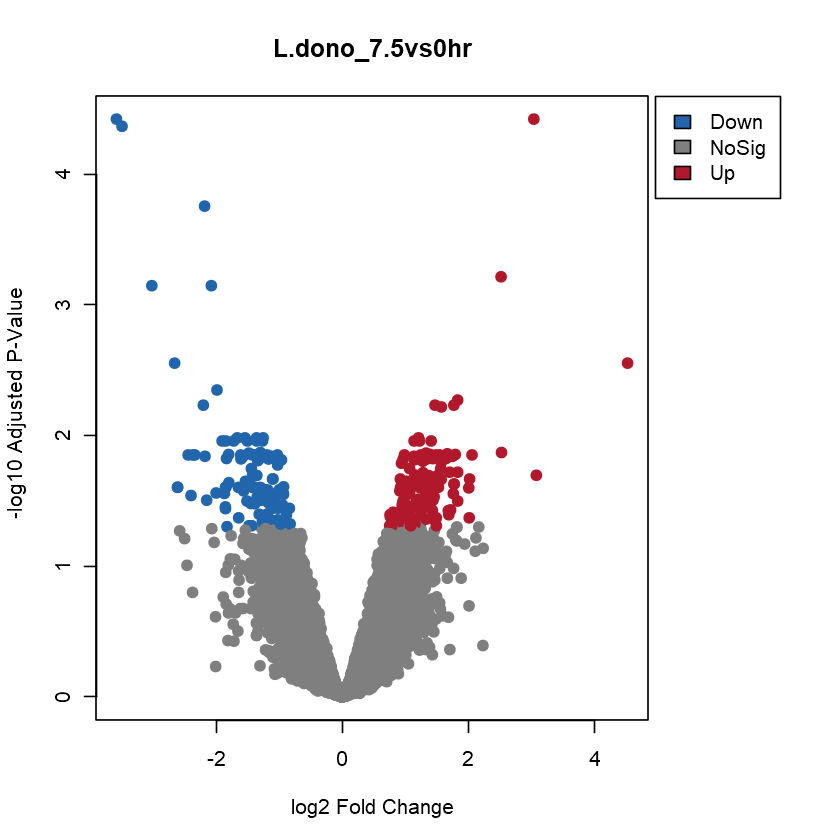

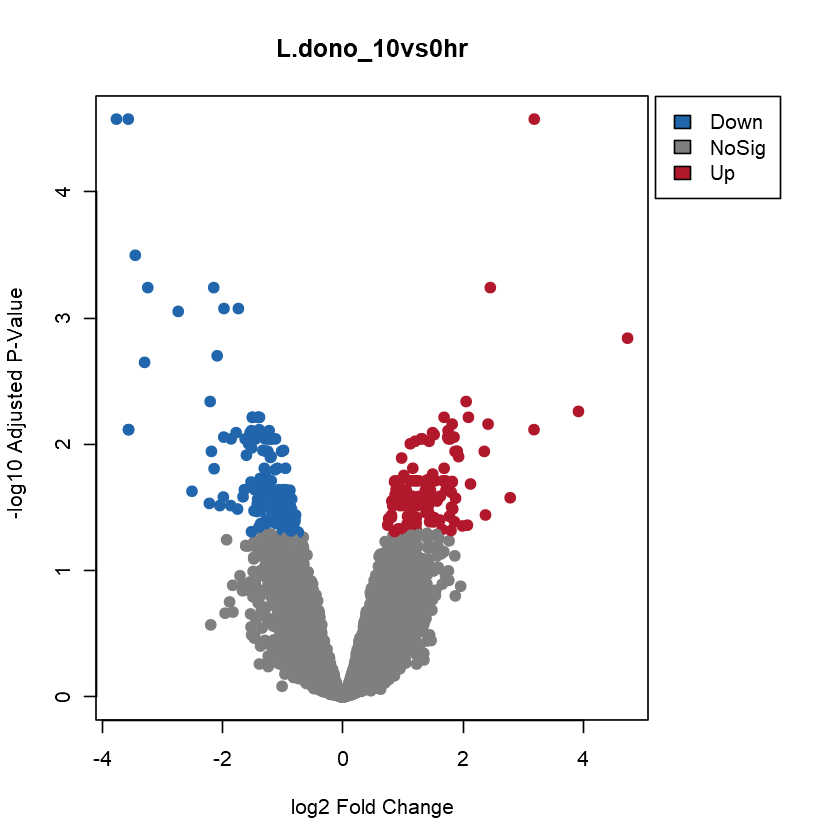

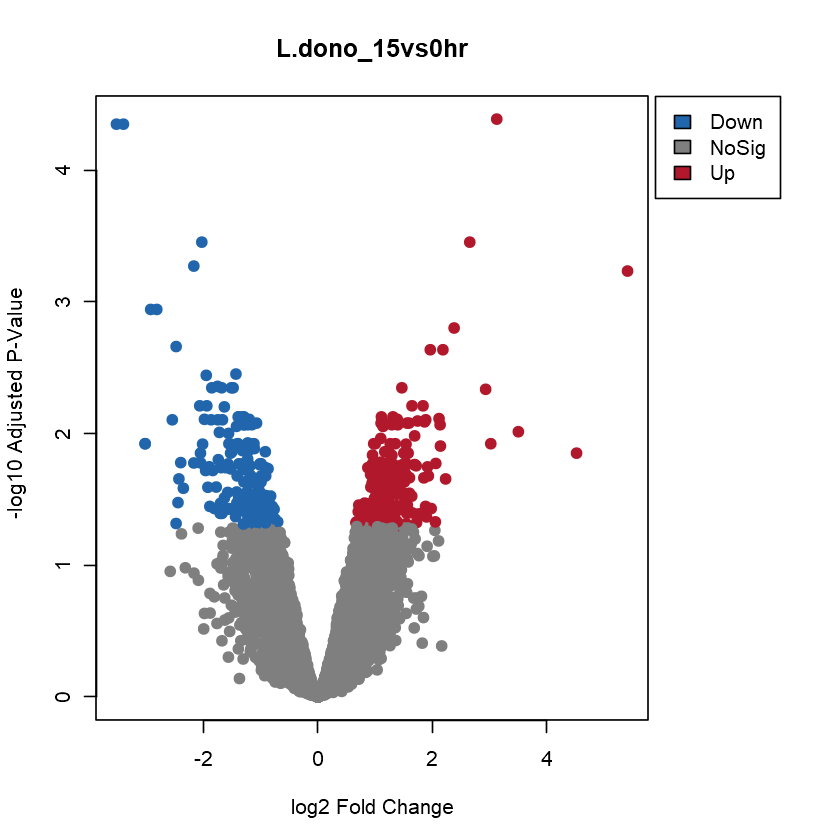

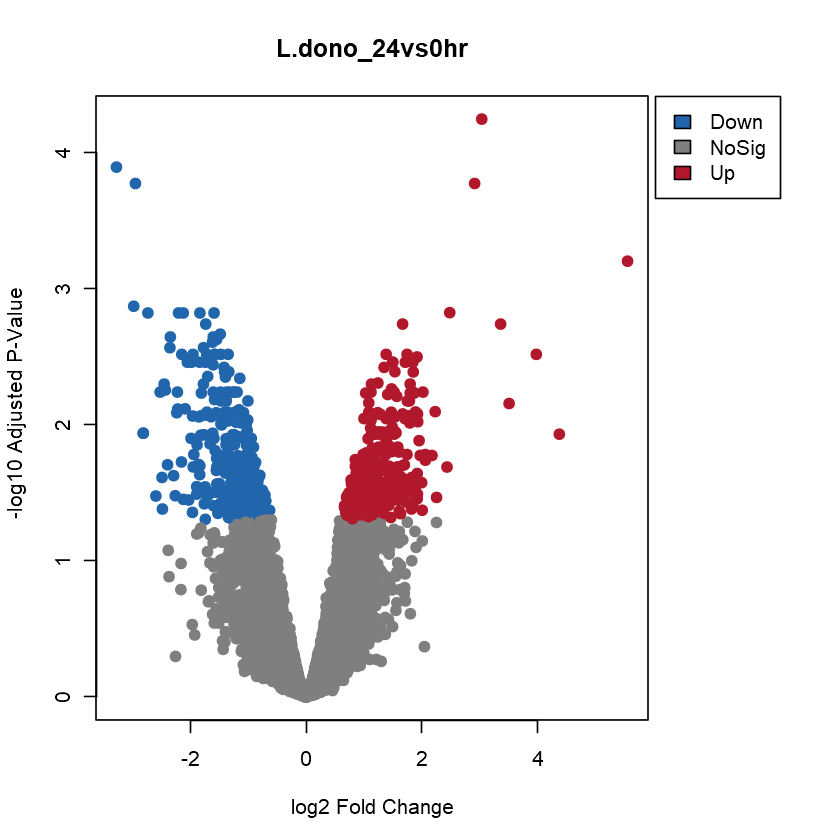

[[1]]
[[1]]$rect
[[1]]$rect$w
[1] 1.595164

[[1]]$rect$h
[1] 0.7445684

[[1]]$rect$left
[1] 3.233172

[[1]]$rect$top
[1] 4.361702


[[1]]$text
[[1]]$text$x
[1] 3.925845 3.925845 3.925845

[[1]]$text$y
[1] 4.175560 3.989418 3.803276



[[2]]
[[2]]$rect
[[2]]$rect$w
[1] 1.689844

[[2]]$rect$h
[1] 0.7781199

[[2]]$rect$left
[1] 3.660309

[[2]]$rect$top
[1] 4.558245


[[2]]$text
[[2]]$text$x
[1] 4.394095 4.394095 4.394095

[[2]]$text$y
[1] 4.363715 4.169185 3.974655



[[3]]
[[3]]$rect
[[3]]$rect$w
[1] 1.983592

[[3]]$rect$h
[1] 0.7847678

[[3]]$rect$left
[1] 4.963493

[[3]]$rect$top
[1] 4.597292


[[3]]$text
[[3]]$text$x
[1] 5.824834 5.824834 5.824834

[[3]]$text$y
[1] 4.401101 4.204909 4.008717



[[4]]
[[4]]$rect
[[4]]$rect$w
[1] 2.079356

[[4]]$rect$h
[1] 0.8125334

[[4]]$rect$left
[1] 5.194276

[[4]]$rect$top
[1] 4.760072


[[4]]$text
[[4]]$text$x
[1] 6.097201 6.097201 6.097201

[[4]]$text$y
[1] 4.556939 4.353806 4.150672



[[5]]
[[5]]$rect
[[5]]$rect$w
[1] 2.185817

[[5]]$rect$h
[1] 0.7790347

[[5]]$rect$left
[1] 5.897398

[[5]]$rect$top
[1] 4.563609


[[5]]$text
[[5]]$text$x
[1] 6.846552 6.846552 6.846552

[[5]]$text$y
[1] 4.368851 4.174092 3.979333



[[6]]
[[6]]$rect
[[6]]$rect$w
[1] 2.161649

[[6]]$rect$h
[1] 0.7541283

[[6]]$rect$left
[1] 6.033842

[[6]]$rect$top
[1] 4.41771


[[6]]$text
[[6]]$text$x
[1] 6.972502 6.972502 6.972502

[[6]]$text$y
[1] 4.229178 4.040646 3.852114



[[7]]
[[7]]$rect
[[7]]$rect$w
[1] 2.35086

[[7]]$rect$h
[1] 0.9083351

[[7]]$rect$left
[1] 6.125044

[[7]]$rect$top
[1] 5.321086


[[7]]$text
[[7]]$text$x
[1] 7.145865 7.145865 7.145865

[[7]]$text$y
[1] 5.094002 4.866919 4.639835

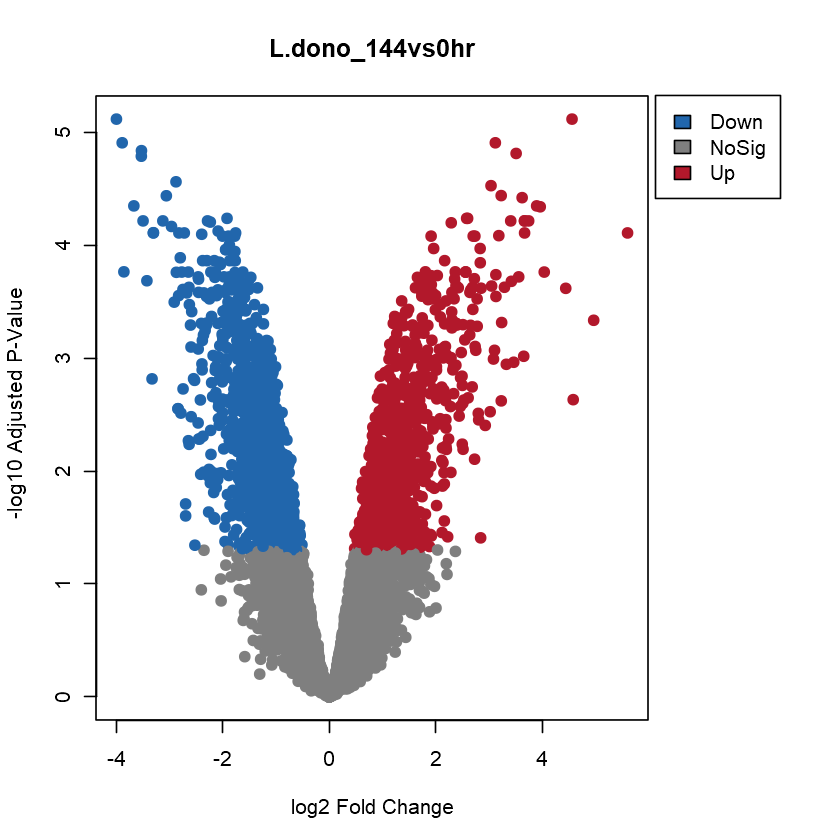

In [123]:
# chosing different color for up, down and not regulated probes.
ma.cols <- c(brewer.pal(11, "RdBu")[10], "grey50", brewer.pal(11, "RdBu")[2])
names(ma.cols)<-c(-1,0,1)

names<-names(my.unique.results)
lapply(names,function(x){
    
#         svg(file=paste0("results/SamplesPlot/VolcanoPlot/",x,"_VolcanoPlot.svg"))
        par(mar=c(5,4,4,8),xpd=TRUE)
        
        legend<-c("Down","NoSig","Up")  
        row.colors <- unname(ma.cols[as.character(contrast.tests[[x]][, 1])])
        
        plot(contrast.tts[[x]]$logFC, 
             -log10(contrast.tts[[x]]$adj.P.Val), 
             col=row.colors, pch=19, main=x, 
             xlab="log2 Fold Change", ylab="-log10 Adjusted P-Value")
#         abline(h=-log10(0.05))
#         abline(v=1,col="red")
#         abline(v=-1,col="blue")
        legend("topright",inset=c(-0.24,0), legend=legend, 
               fill=unname(ma.cols))
#         dev.off()
    })

## Histone and associated Genes

In [158]:
filter_genes<-read.table(file=paste0("results/OnlyHistoneGenes.txt")
                              ,header=T,sep="\t",quote="")

In [159]:
head(filter_genes,10)

,ID,ORF,Product,Symbol,stage,logFC,test
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
1,4768688,LinJ09.1400,histone H2B,N/A,L.dono_2.5hr,0.54985957,0
2,4771886,LinJ27.0830,putative histone H1,N/A,L.dono_2.5hr,0.04068989,0
3,4772609,LinJ29.2000,histone H2A - putative,N/A,L.dono_2.5hr,-0.12352934,0
4,4774147,LinJ33.3030,h1 histone-like protein,N/A,L.dono_2.5hr,0.27072562,0
5,4770258,LinJ20.0030,histone-lysine N-methyltransferase - putative,DOT1B,L.dono_2.5hr,-0.23265582,0
6,4774746,LinJ35.1400,histone H4,N/A,L.dono_2.5hr,-0.13337585,0
7,4768296,LinJ07.0030,histone-lysine N-methyltransferase - putative,DOT1A,L.dono_2.5hr,-0.02881678,0
8,4768532,LinJ08.1190,histone deacetylase - putative,N/A,L.dono_2.5hr,-0.51034775,0
9,4772089,LinJ28.0210,histone H2B variant,H2BV,L.dono_2.5hr,-0.62783710,0


In [160]:
filter_ids<-as.data.frame(filter_genes[!duplicated(filter_genes$ID),]$ID)
colnames(filter_ids)<-c("ID")
head(filter_ids)

,ID
,<int>
1,4768688
2,4771886
3,4772609
4,4774147
5,4770258
6,4774746


In [161]:
combined_filter_genes<-merge(combined,filter_ids,by="ID")
head(combined_filter_genes,5)

,ID,ORF,Product,Symbol,L.dono_2.5vs0hr_logFC,L.dono_2.5vs0hr_test,L.dono_5vs0hr_logFC,L.dono_5vs0hr_test,L.dono_7.5vs0hr_logFC,L.dono_7.5vs0hr_test,L.dono_10vs0hr_logFC,L.dono_10vs0hr_test,L.dono_15vs0hr_logFC,L.dono_15vs0hr_test,L.dono_24vs0hr_logFC,L.dono_24vs0hr_test,L.dono_144vs0hr_logFC,L.dono_144vs0hr_test
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4768296,LinJ07.0030,histone-lysine N-methyltransferase - putative,DOT1A,-0.02881678,0,-0.2797826,0,-0.3166251,0,-0.7496173,0,-0.66622467,0,-0.7447350,0,-1.5364153,-1
2,4768532,LinJ08.1190,histone deacetylase - putative,N/A,-0.51034776,0,-0.4872358,0,-0.7095156,0,-0.1788375,0,-0.64217111,0,-1.0259987,-1,-0.8536914,-1
3,4768688,LinJ09.1400,histone H2B,N/A,0.54985957,0,0.9303892,0,0.7122074,0,0.9809229,0,0.87610011,0,1.1573575,1,1.0980082,1
4,4770258,LinJ20.0030,histone-lysine N-methyltransferase - putative,DOT1B,-0.23265582,0,-0.1878795,0,-0.1860834,0,-0.4153326,0,-0.35367510,0,-0.6813552,0,-1.5500110,-1
5,4771886,LinJ27.0830,putative histone H1,N/A,0.04068989,0,0.1855175,0,0.2787626,0,0.5774927,0,0.06774567,0,0.2237997,0,1.2537393,1


In [69]:
getwd()

[1] "D:/biological data analysis/Parasites/Plasmodium falciparum 3D7/GSE32427"

In [162]:
write.table(combined_filter_genes, 
            file=paste0("results/",my.gse,"_HistoneRelatedGenes.txt"), 
            sep="\t", quote=F, row.names=FALSE)

In [164]:
significant_filter_genes<-merge(significant.genes,
                                          filter_ids,
                                           by="ID")
head(significant_filter_genes,5)

,ID,ORF,Product,Symbol,L.dono_2.5vs0hr_logFC,L.dono_2.5vs0hr_test,L.dono_5vs0hr_logFC,L.dono_5vs0hr_test,L.dono_7.5vs0hr_logFC,L.dono_7.5vs0hr_test,L.dono_10vs0hr_logFC,L.dono_10vs0hr_test,L.dono_15vs0hr_logFC,L.dono_15vs0hr_test,L.dono_24vs0hr_logFC,L.dono_24vs0hr_test,L.dono_144vs0hr_logFC,L.dono_144vs0hr_test
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4768296,LinJ07.0030,histone-lysine N-methyltransferase - putative,DOT1A,-0.02881678,0,-0.2797826,0,-0.3166251,0,-0.7496173,0,-0.66622467,0,-0.7447350,0,-1.5364153,-1
2,4768532,LinJ08.1190,histone deacetylase - putative,N/A,-0.51034776,0,-0.4872358,0,-0.7095156,0,-0.1788375,0,-0.64217111,0,-1.0259987,-1,-0.8536914,-1
3,4768688,LinJ09.1400,histone H2B,N/A,0.54985957,0,0.9303892,0,0.7122074,0,0.9809229,0,0.87610011,0,1.1573575,1,1.0980082,1
4,4770258,LinJ20.0030,histone-lysine N-methyltransferase - putative,DOT1B,-0.23265582,0,-0.1878795,0,-0.1860834,0,-0.4153326,0,-0.35367510,0,-0.6813552,0,-1.5500110,-1
5,4771886,LinJ27.0830,putative histone H1,N/A,0.04068989,0,0.1855175,0,0.2787626,0,0.5774927,0,0.06774567,0,0.2237997,0,1.2537393,1


In [165]:
dim(significant_filter_genes)

[1]  9 18

In [166]:
write.table(significant_filter_genes, 
                file=paste0("results/",my.gse,"_SignificantHistoneRelatedGenes.txt"), 
            sep="\t", quote=F, row.names=FALSE)

## ScatterPlot


In [3]:
# setwd('GSE21936_L.dono_L.infantum/')
getwd()

[1] "D:/biological data analysis/Parasites/GSE21936_L.dono_L.infantum"

In [4]:
library(ggplot2)

In [5]:
histo<-read.table("results/GSE21936_HistoneRelatedGenes_ggplot.txt",header=T,sep="\t",quote="")
head(histo)

,Product,Symbol,stage,logFC,test
,<chr>,<chr>,<chr>,<dbl>,<int>
1,histone-lysine N-methyltransferase - putative,DOT1A,L.dono_24hr,-0.7447350,0
2,histone deacetylase - putative,HDAC,L.dono_24hr,0.1633349,0
3,histone deacetylase - putative,HDAC,L.dono_24hr,-1.0259987,-1
4,histone acetyltransferase - putative,HAT,L.dono_24hr,0.3049103,0
5,histone-lysine N-methyltransferase - putative,DOT1B,L.dono_24hr,-0.6813552,0
6,histone deacetylase - putative,HDAC,L.dono_24hr,0.8029396,0


In [6]:
library(repr)

In [7]:
unique(histo$stage)

[1] "L.dono_24hr"  "L.dono_144hr"

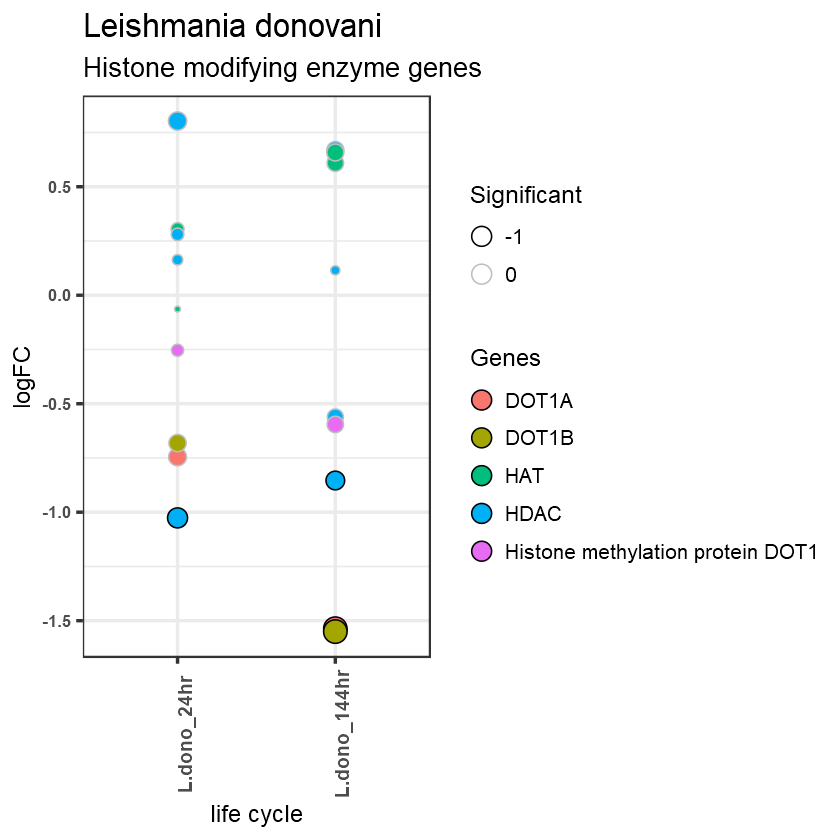

In [8]:
# svg(file="results/HistoneRelatedPLot.svg") 
# options(repr.plot.width=10,repr.plot.height=10)

theme_set(theme_bw(base_size = 16))  # pre-set the bw theme.
x_axis_order<-c('L.dono_24hr','L.dono_144hr')
size<-abs(histo$logFC)
Significant<-factor(histo$test)
Genes<-histo$Symbol
# gene.cols <- c("histone h4" = "red", "histone H2A, putative" = "blue", "histone H2B" = "green", 
#                "histone H2B variant" = "pink", "h1 histone-like protein"="yellow")

g <- ggplot(histo, aes(factor(stage, level = x_axis_order),
                                   logFC))+
    geom_point(aes(fill=Genes,size=size,col=Significant),shape=21) +

    scale_colour_manual(values = c("black", "gray", "black"))+
#     scale_fill_manual(values=gene.cols)+

    guides(size = FALSE, fill = guide_legend(override.aes = list(size=5)),
          color = guide_legend(override.aes = list(size=5)))+
    theme(axis.text.x = element_text(face="bold",size=11,angle=90),
          axis.text.y = element_text(face="bold",size=10),
          legend.title = element_text(color="black",size = 14),
          legend.text = element_text(color = "black", size = 12),
          legend.key.size = unit(0.8, "cm"),
#           legend.key.size = unit(3,"line"),
          legend.key.width = unit(0.5,"cm") ,
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
          
          )+
  labs(subtitle="Histone modifying enzyme genes", 
       y="logFC",
       x="life cycle",
       title="Leishmania donovani"
#        caption="life cycle"
      )
g
# dev.off()

In [10]:
# ggsave(file="results/OnlyHistonePlot.svg", plot=g, width=10, height=10)
ggsave(file="results/OnlyHistonePlot.svg", plot=g)

Saving 6.67 x 6.67 in image

